In [2]:
import pandas as pd
import numpy as np
import geopandas as gd
import matplotlib.pylab as pl
from fiona.crs import from_epsg
import fiona
from matplotlib import colors
import shapely
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap    
from tqdm import tqdm, trange
import warnings; 
warnings.simplefilter('ignore')
#warnings.filterwarnings(action='once')
import gc
import IPython
from tqdm import tqdm, tqdm_notebook
%matplotlib inline
pd.set_option('display.height',1000)
pd.set_option('display.max_row',500)
pd.set_option('display.max_columns',500)
pd.set_option("display.width", 1000)

height has been deprecated.



### Objective
The ojective of this notebook is to develop a code capable of assigning a Water Districts to each one of the Block Groups in the state of California. The metogology consists in will be described in detail below.

### Methodology:
    
    Asigning function in two parts:
    
    assign_water_district: The function receives the block group polygons and send the centroids to a secondary function with the water district polygon, the PWSID (Water District ID), and PWSID_Series which stores the matching water districts.
    
    compare_wa_bg: This function verifies which water districts polygons contain the centroid of the block group, and stores in PWSID_series the PWSID. The reason of storing the result in a list is because some blockgroups are contained by more than one water districts, this situation will be referred as Overlap. 
        
The list WSID_series is stored in the blockgroup dataframe in the column PWSID

In [16]:


tqdm_notebook().pandas()

def assign_water_district (bg_geo):
    PWSID_series = []

    x = data_wa.apply(lambda row: compare_wa_bg(bg_geo.centroid, row['geometry'], row['pwsid'], PWSID_series), axis=1)

    return x

bad_polygons=[]

def compare_wa_bg (bg_geo, wa_geo, pwsid, PWSID_series):

    try:
        if wa_geo.contains(bg_geo):
            PWSID_series.append(pwsid)

    except:
        bad_polygons.append(pwsid)

    return PWSID_series




In [17]:
## suppliers.geojson provided by CADC
data_wa = gd.read_file("../Data/Supplier/suppliers.geojson")
print 'Total Water Districts in California: ', data_wa.shape[0]

Total Water Districts in California:  410


### Water Districts Polygon Errors

The following code excludes from the process the Water Districts with polygons that have self-intersection errors. It is not possible to perform geometrical operations with this polygons.
It is neccesary to edit these 6 polygons. (Water Districts)

In [18]:
bad_poly =[u'CA0310002', u'CA3310037', u'CA1910005',u'CA3410002',u'CA3310051', u'CA1610005']
mask = []
for i in data_wa.pwsid:
    if i in bad_poly:
        mask.append(True)
    else:
        mask.append(False)

In [62]:
data_wa[mask].head()

,cartodb_id,city,county,detailed_c,displayed,general_ch,geom_3310,geometry,gid,parcels_in,pwsid,reference,sbx7_7_tar,supplier_n,to_be_proc,utility_id
0,219,,,,1,N/A,0106000020EE0C00000100000001030000000100000069...,"(POLYGON ((-122.000388 37.34519, -122.000371 3...",78,0,CA4310001,,1,California Water Service Company Los Altos/Sub...,0,227
1,10,SAN BERNARDINO,SAN BERNARDINO,,1,N/A,0106000020EE0C0000040000000103000000010000000B...,"(POLYGON ((-117.40553 34.22197, -117.40553 34....",165,0,CA3610039,,1,San Bernardino City of,0,9
2,228,SANTA CLARA,SANTA CLARA,,1,N/A,0106000020EE0C000001000000010300000001000000FE...,"(POLYGON ((-121.986149 37.412066, -121.985204 ...",170,0,CA4310012,,1,Santa Clara City of,0,236
3,373,OAKLAND,ALAMEDA,,1,N/A,0106000020EE0C000001000000010300000012000000B8...,"(POLYGON ((-122.233011 38.021545, -122.228697 ...",332,0,CA0110005,,1,East Bay Municipal Utilities District,0,384
4,371,REDDING,SHASTA,,1,N/A,0106000020EE0C0000020000000103000000010000001C...,"(POLYGON ((-122.278084 40.467865, -122.278841 ...",389,0,CA4510005,,1,Redding City of,0,382


CA1610005 LEMOORE

Self-intersection at or near point -119.79428 36.314369999999997


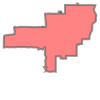

In [20]:
print data_wa.pwsid[311],data_wa.city[311],
data_wa.geometry[311]

CA3310051 BERMUDA DUNES

Self-intersection at or near point -116.29939165116279 33.758140069767443


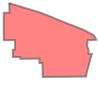

In [21]:
print data_wa.pwsid[297],data_wa.city[297],
data_wa.geometry[297]

CA3410002 SACRAMENTO

Self-intersection at or near point -121.20166561015976 38.497760334567474


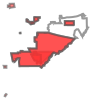

In [22]:
print data_wa.pwsid[111],data_wa.city[111],
data_wa.geometry[111]

CA0310002 JACKSON

Self-intersection at or near point -120.80770800000001 38.402748000000003


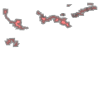

In [23]:
print data_wa.pwsid[147],data_wa.city[147],
data_wa.geometry[147]


CA3310037 CORONA

Too few points in geometry component at or near point -117.50911000000001 33.799390000000002


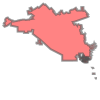

In [24]:
print data_wa.pwsid[94],data_wa.city[94],
data_wa.geometry[94]


CA1910005 ALHAMBRA

Self-intersection at or near point -117.80953927676234 34.631182274433115


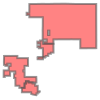

In [25]:
print data_wa.pwsid[261],data_wa.city[261],
data_wa.geometry[261]


In [26]:
mask = []
for i in data_wa.pwsid:
    if i in bad_poly:
        mask.append(False)
    else:
        mask.append(True)
data_wa = data_wa[mask]
print 'Total Water Districts with Valid Polygons:', data_wa.shape[0]

Total Water Districts with Valid Polygons: 404


In [27]:
### Load California Census Block Groups, downloaded from census bureau website url=
bg10 = gd.read_file("../Data/GeoData/BG2010/tl_2010_06_bg10.shp")
bg10['PWSID']= np.nan

### Apply fuction that assigns a water district to each block group, for details review Methodology
bg10['PWSID'] = bg10['geometry'].progress_apply(assign_water_district)
listone = bg10['PWSID'].tolist()

# df only contrains the column PWSID
df = pd.DataFrame()
df['one']=listone
df.to_csv("../Data/GeoData/BG2010/All.csv")
print 'Bad polygons: ', set(bad_polygons)

#Store blockgroup dataframe as geojson, it contains the assigned Water district
with open('../Data/GeoData/BG2010/tl_2010_06_bg10_Complete.geojson', 'w') as f:
            f.write(bg10.to_json())



Bad polygons:  set([])


#### Cleaning the result

The label Overlap is assigned to the block groups with more than one Water District and the list is stored as a string, this allow the dataframe to be stored in different formats. 

In [28]:
def getemout(x):
    if x!=[]:
        if len(x)>1:
            return 'Overlap'
        else:
            return x[0]
    else:
        return np.nan
    
def getstring(x):
    if x!=[]:
        if len(x)>1:
            return str(tuple(x)).replace("u'",'').replace("'","").replace('(','').replace(')','')
        else:
            return x[0]
    else:
        return np.nan
df['clean'] = df.one.map(getemout)
df['pwsid_str'] = df.one.map(getstring)

In [29]:
bg10['PWSID'] = df['clean']
bg10['PWSID_str'] = df['pwsid_str']
# store dataframe as shapefile
bg10.to_file('../Data/GeoData/BG2010/tl_2010_06_bg10_Complete')

In [30]:
bg10_2 = gd.read_file("../Data/GeoData/BG2010/tl_2010_06_bg10_Complete/tl_2010_06_bg10_Complete.shp")
bg10_2.head() 

,ALAND10,AWATER10,BLKGRPCE10,COUNTYFP10,FUNCSTAT10,GEOID10,INTPTLAT10,INTPTLON10,MTFCC10,NAMELSAD10,PWSID,PWSID_str,STATEFP10,TRACTCE10,geometry
0,1570668,0,3,053,S,060530107013,+36.6007541,-121.7026925,G5030,Block Group 3,None,None,06,010701,"POLYGON ((-121.695295 36.611978, -121.695835 3..."
1,35803170,6990,1,053,S,060530107011,+36.5638185,-121.6697325,G5030,Block Group 1,None,None,06,010701,"POLYGON ((-121.716432 36.575879, -121.716564 3..."
2,117598808,7423555,2,053,S,060530108042,+36.4990122,-121.4841399,G5030,Block Group 2,None,None,06,010804,"POLYGON ((-121.441117 36.506671, -121.440689 3..."
3,460033,0,1,053,S,060530009001,+36.6705248,-121.6316814,G5030,Block Group 1,CA2710010,CA2710010,06,000900,"POLYGON ((-121.628045 36.666709, -121.628092 3..."
4,1025437,0,3,053,S,060530009003,+36.6679218,-121.6217053,G5030,Block Group 3,CA2710010,CA2710010,06,000900,"POLYGON ((-121.617367 36.671523, -121.616931 3..."


In [31]:
##store it as geojson 
with open('../Data/GeoData/BG2010/tl_2010_06_bg10_Complete.geojson', 'w') as f:
    f.write(bg10.to_json())

### Exploring Overlaps

In [61]:
print 'Total Block Groups: ',bg10_2.shape[0]
print 'Block Groups with Overlap: ',bg10_2[bg10_2.PWSID=='Overlap'].shape[0]

Total Block Groups:  23212
Block Groups with Overlap:  1364


In [33]:
data_wa = gd.read_file("../Data/Supplier/suppliers.geojson")

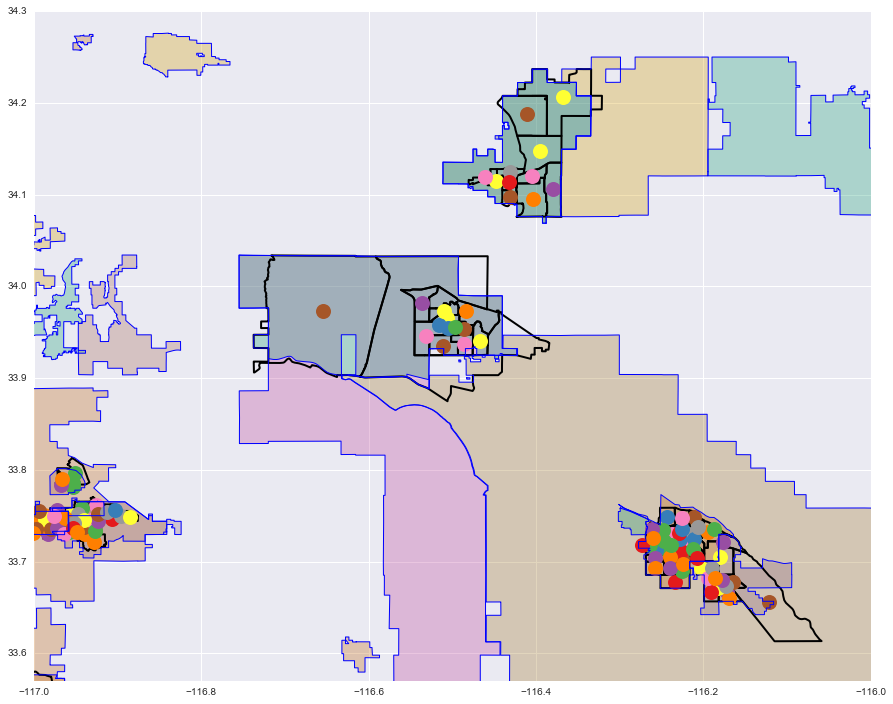

In [34]:
f, ax = plt.subplots(figsize=(15,12))

#state[state.NAME=='California'].plot(ax=ax, c = 'k', linewidth = 2,  color= 'Green', alpha=.5)
plt.xlim(-117,-116)
plt.ylim(33.57,34.3)
bg10_2[bg10_2.PWSID=='Overlap'].plot(ax=ax, edgecolor = 'k', linewidth = 2, alpha=.3, color='None')
bg10_2[bg10_2.PWSID=='Overlap'].geometry.centroid.plot(ax=ax, markersize=15)
data_wa.plot(ax=ax, edgecolor = 'b', linewidth = 1, cmap='Dark2', alpha=.3)

#data_wa.plot(ax=ax, edgecolor = 'w', linewidth = .5,  color= 'Gray', alpha=.8)

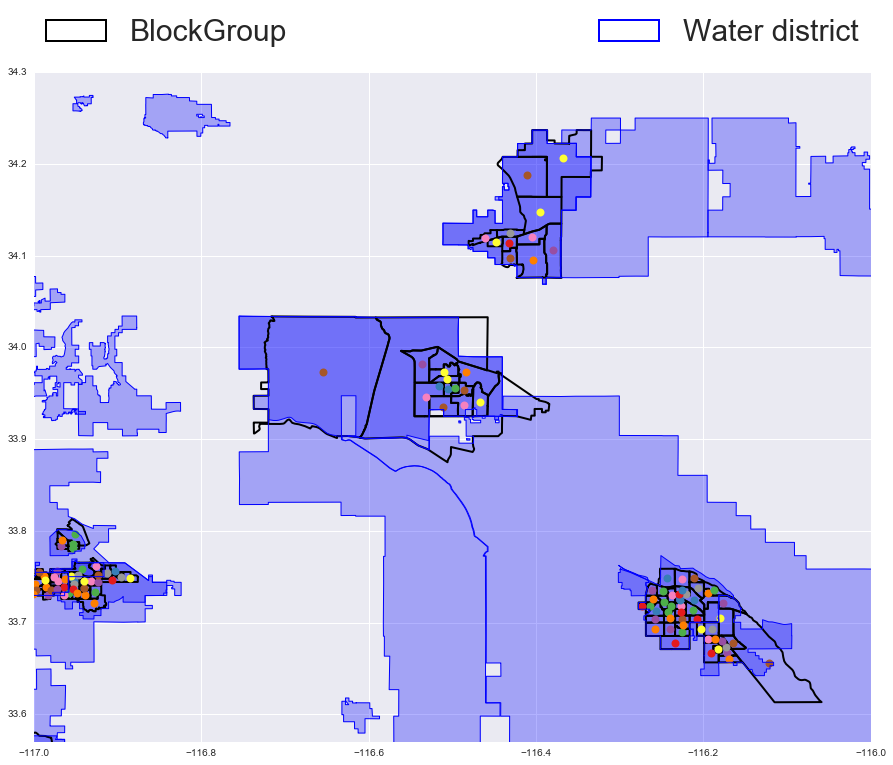

In [35]:
import matplotlib.patches as mpatches
f, ax = plt.subplots(figsize=(15,12))

#state[state.NAME=='California'].plot(ax=ax, c = 'k', linewidth = 2,  color= 'Green', alpha=.5)
plt.xlim(-117,-116)
plt.ylim(33.57,34.3)
bg10_2[bg10_2.PWSID=='Overlap'].plot(ax=ax, edgecolor = 'k', linewidth = 2, alpha=.3, color='None')
bg10_2[bg10_2.PWSID=='Overlap'].geometry.centroid.plot(ax=ax, markersize=8)
data_wa.plot(ax=ax, edgecolor = 'b', linewidth = 1, color='Blue', alpha=.3)


patch15 = mpatches.Patch(color='k', label='BlockGroup',fill=False, edgecolor='k', linewidth=2)
patch30 = mpatches.Patch(color='b', label='Water district', fill=False,  edgecolor='b', linewidth=2)


plt.legend(handles=[patch15,patch30], fontsize=30, bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

#data_wa.plot(ax=aedgecolor = 'w', linewidth = .5,  color= 'Gray', alpha=.8)

In [64]:
wa=[]
for i in set(bg10_2[bg10_2.PWSID=='Overlap'].PWSID_str.tolist()):
    #print i
    for j in i.split(', '):
        wa.append(j)

In [65]:
print 'Water Districts affected by Overlap:', len(set(wa))

Water Districts affected by Overlap: 162


In [66]:
mask3=[]
for x in data_wa.pwsid:
    if x in set(wa):
        mask3.append(True)
    else:
        mask3.append(False)

In [67]:
#Overlap Affected Water Districts 
data_wa[mask3].head()

,cartodb_id,city,county,detailed_c,displayed,general_ch,geom_3310,geometry,gid,parcels_in,pwsid,reference,sbx7_7_tar,supplier_n,to_be_proc,utility_id
0,219,,,,1,N/A,0106000020EE0C00000100000001030000000100000069...,"(POLYGON ((-122.000388 37.34519, -122.000371 3...",78,0,CA4310001,,1,California Water Service Company Los Altos/Sub...,0,227
1,10,SAN BERNARDINO,SAN BERNARDINO,,1,N/A,0106000020EE0C0000040000000103000000010000000B...,"(POLYGON ((-117.40553 34.22197, -117.40553 34....",165,0,CA3610039,,1,San Bernardino City of,0,9
3,373,OAKLAND,ALAMEDA,,1,N/A,0106000020EE0C000001000000010300000012000000B8...,"(POLYGON ((-122.233011 38.021545, -122.228697 ...",332,0,CA0110005,,1,East Bay Municipal Utilities District,0,384
4,371,REDDING,SHASTA,,1,N/A,0106000020EE0C0000020000000103000000010000001C...,"(POLYGON ((-122.278084 40.467865, -122.278841 ...",389,0,CA4510005,,1,Redding City of,0,382
5,13,EUREKA,HUMBOLDT,,1,N/A,0106000020EE0C00000100000001030000000100000025...,"(POLYGON ((-124.130344 40.948779, -124.13017 4...",392,0,CA1210013,,0,Humboldt Bay Municipal Water District,0,12


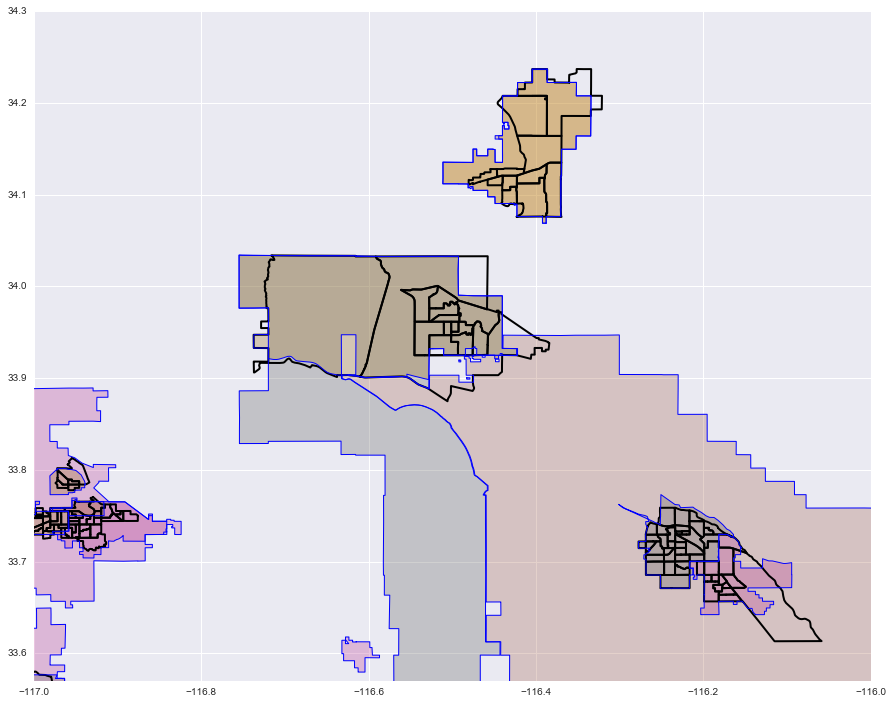

In [40]:
f, ax = plt.subplots(figsize=(15,12))

#state[state.NAME=='California'].plot(ax=ax, c = 'k', linewidth = 2,  color= 'Green', alpha=.5)
plt.xlim(-117,-116)
plt.ylim(33.57,34.3)
bg10_2[bg10_2.PWSID=='Overlap'].plot(ax=ax, edgecolor = 'k', linewidth = 2, alpha=.3, color='None')
data_wa[mask3].plot(ax=ax, edgecolor = 'b', linewidth = 1, cmap='Dark2', alpha=.3)

#data_wa.plot(ax=ax, edgecolor = 'w', linewidth = .5,  color= 'Gray', alpha=.8)

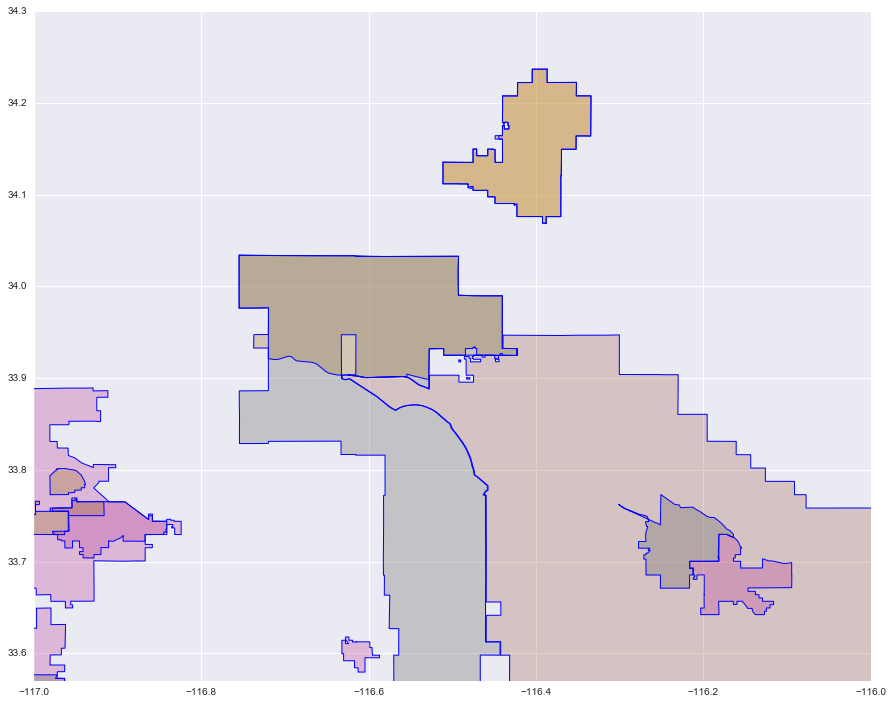

In [41]:
f, ax = plt.subplots(figsize=(15,12))

#state[state.NAME=='California'].plot(ax=ax, c = 'k', linewidth = 2,  color= 'Green', alpha=.5)
plt.xlim(-117,-116)
plt.ylim(33.57,34.3)
#bg10_2[bg10_2.PWSID=='Overlap'].plot(ax=ax, edgecolor = 'k', linewidth = 2, alpha=.3, color='None')
data_wa[mask3].plot(ax=ax, edgecolor = 'b', linewidth = 1, cmap='Dark2', alpha=.3)

#data_wa.plot(ax=ax, edgecolor = 'w', linewidth = .5,  color= 'Gray', alpha=.8)

### WD polygons review

Not all the warnings produce fatal errors, but must be reviewed.

Self-intersection must be addressed in each polygon


In [42]:
x = data_wa.geometry.is_valid

Too few points in geometry component at or near point -117.3533 34.174370000000003
Self-intersection at or near point -117.023138 32.722254
Ring Self-intersection at or near point -118.36680699999999 35.621881000000002
Self-intersection at or near point -117.15074998812214 33.358207978470681
Self-intersection at or near point -119.00097497010364 36.051810636449254
Too few points in geometry component at or near point -120.32763 37.969889999999999
Too few points in geometry component at or near point -117.50911000000001 33.799390000000002
Ring Self-intersection at or near point -118.050488 34.008893
Ring Self-intersection at or near point -121.09801299999999 38.942042999999998
Too few points in geometry component at or near point -122.28002499999999 37.456144000000002
Ring Self-intersection at or near point -117.90248099999999 34.050398000000001
Self-intersection at or near point -121.20166561015976 38.497760334567474
Self-intersection at or near point -117.304928 34.019188
Ring Self-in

In [51]:
type(x)

pandas.core.series.Series

In [52]:
b=[]
for bool_1 in x:
    b.append(not bool_1)

In [53]:
print data_wa[b].shape

(26, 16)


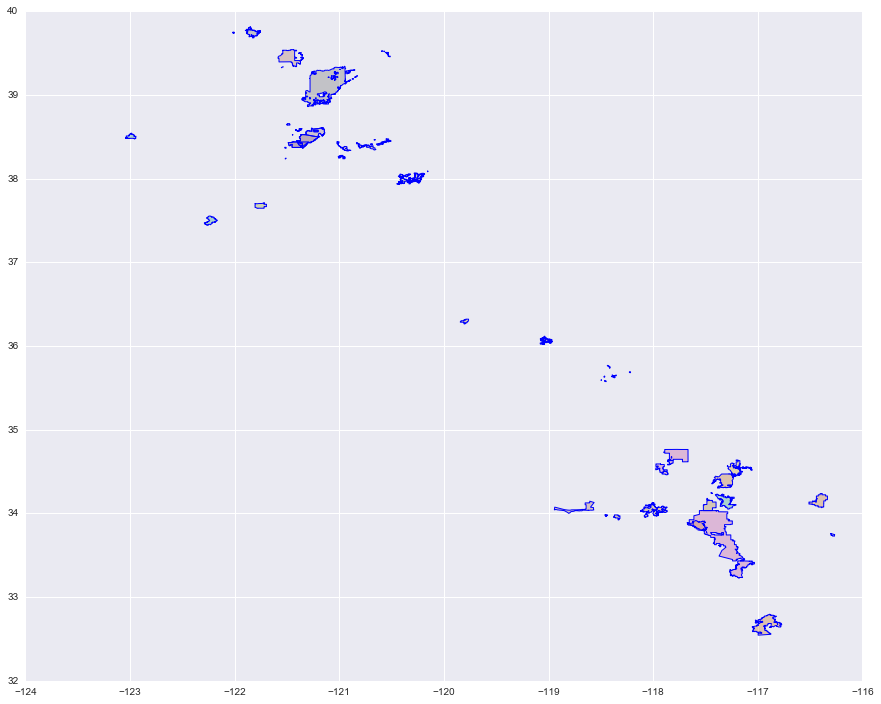

In [54]:
f, ax = plt.subplots(figsize=(15,12))

#state[state.NAME=='California'].plot(ax=ax, c = 'k', linewidth = 2,  color= 'Green', alpha=.5)
#plt.xlim(-117,-116)
#plt.ylim(33.57,34.3)
#bg10_2[bg10_2.PWSID=='Overlap'].plot(ax=ax, edgecolor = 'k', linewidth = 2, alpha=.3, color='None')
data_wa[b].plot(ax=ax, edgecolor = 'b', linewidth = 1, cmap='Dark2', alpha=.3)

#data_wa.plot(ax=ax, edgecolor = 'w', linewidth = .5,  color= 'Gray', alpha=.8)

In [55]:
#Store polygons to review
with open('../Data/GeoData/Water_Districts_polygons_to_review.geojson', 'w') as f:
    f.write(data_wa[b].to_json())

In [56]:
#Sacramento example
data_wa[data_wa.pwsid=='CA3410002']

,cartodb_id,city,county,detailed_c,displayed,general_ch,geom_3310,geometry,gid,parcels_in,pwsid,reference,sbx7_7_tar,supplier_n,to_be_proc,utility_id
111,332,SACRAMENTO,SACRAMENTO,,0,manual boundary update due to PWSID mismatch,0106000020EE0C0000110000000103000000010000000C...,"(POLYGON ((-121.243266 38.577938, -121.202702 ...",136,0,CA3410002,http://www.waterresources.saccounty.net/scwa/D...,1,Sacramento County Water Agency,1,263


Self-intersection at or near point -121.20166561015976 38.497760334567474


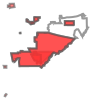

In [57]:
data_wa[b].geometry[111]

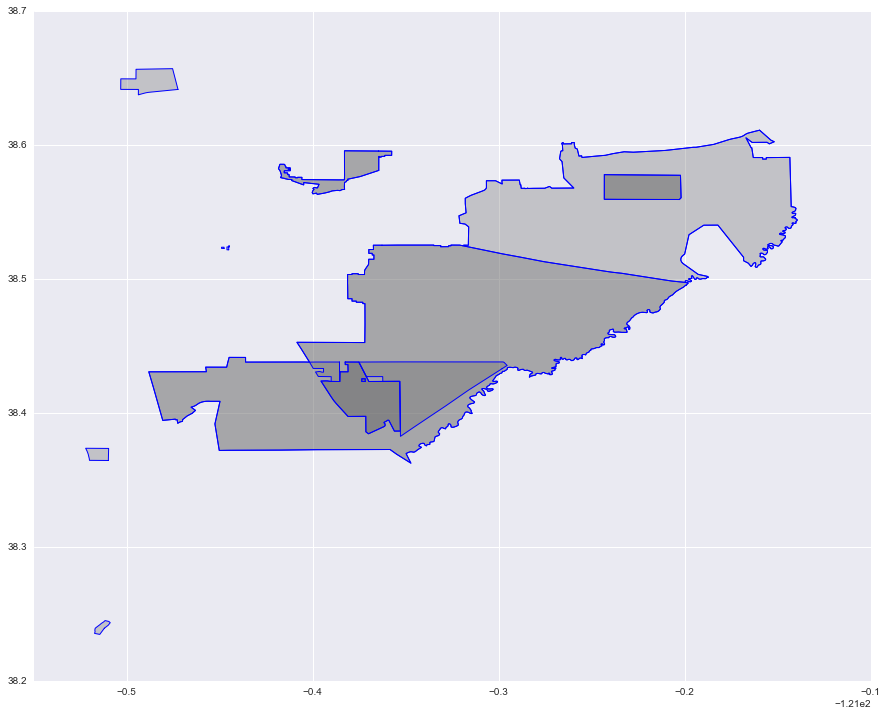

In [58]:
f, ax = plt.subplots(figsize=(15,12))

#state[state.NAME=='California'].plot(ax=ax, c = 'k', linewidth = 2,  color= 'Green', alpha=.5)
#plt.xlim(-117,-116)
#plt.ylim(33.57,34.3)
#bg10_2[bg10_2.PWSID=='Overlap'].plot(ax=ax, edgecolor = 'k', linewidth = 2, alpha=.3, color='None')
data_wa[data_wa.pwsid=='CA3410002'].plot(ax=ax, edgecolor = 'b', linewidth = 1, cmap='Dark2', alpha=.3)
